# Form Ilastik Masks to Labels
<div class="custom-button-row">
    <a 
        class="custom-button custom-download-button" href="../../../notebooks/05_segmentation/machine_learning/from_ilastik_masks_to_labels.ipynb" download>
        <i class="fas fa-download"></i> Download this Notebook
    </a>
    <a
    class="custom-button custom-download-button" href="https://colab.research.google.com/github/HMS-IAC/bobiac/blob/gh-pages/colab_notebooks/05_segmentation/machine_learning/from_ilastik_masks_to_labels.ipynb" target="_blank">
        <img class="button-icon" src="../../../_static/logo/icon-google-colab.svg" alt="Open in Colab">
        Open in Colab
    </a>
</div>

In [ ]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "matplotlib",
#     "ndv[jupyter,vispy]",
#     "scikit-image",
#     "scipy",
#     "tifffile",
#     "imagecodecs",
# ]
# ///

## <p class="alert alert-success">Description</p>

This notebook demonstrates how to convert the *semantic segmentation* generated by **Ilastik** into *instance segmentation* (Note: Ilastik provides a basic workflow for that as well, but it might not be always sufficient: [from probabilities to a segmentation](https://www.ilastik.org/documentation/objects/objects#from-probabilities-to-a-segmentation---threshold-and-size-filter-applet))

We first explore the type of data that we generated with Ilastik in the previous section ([**Machine Learning: Ilastik**](./machine_learning_with_ilastik.md)) and we then use them to generate labels, which can be used for instance segmentation (as we did in [classic segmentastion methods](../classic/classic.md)).

***TODO: UPDATE LINK TO CLASSIC SEGMENTATION METHODS SECTION***

### <p class="alert alert-info">Import libraries</p>

In [ ]:
import tifffile
import ndv
from scipy import ndimage
from skimage import measure, segmentation, morphology, color
import matplotlib.pyplot as plt

### <p class="alert alert-info">Explore the data</p>

Let's first load one of the *_Simple Segmentation.tif* files and explore the data that we generated with Ilastik. We want to know the type of data that we have before we can convert it to labels (instance segmentation).

Choose one of the *_Simple Segmentation.tif* files path and store it in a variable called `seg_path`.

In [46]:
# set the path to one of the *_Simple Segmentation.tif files
seg_path = "../../../_static/images/ilastik/ilastik_simple_seg_example.tif"

We can use the `tifffile` library to read the tif file.

In [47]:
# Load a mask
seg = tifffile.imread(seg_path)

What is the data type?

In [48]:
print(seg.dtype)
print(type(seg))

uint8
<class 'numpy.ndarray'>


With can now use the `ndv` library to display the data and **explore the pixel values**.

In [ ]:
# show the mask image
ndv.imshow(seg)

In [ ]:
viewer = ndv.imshow(seg)

In [ ]:
viewer.widget().children[1].snapshot()

What are the pixel values? Are they binary (0 and 1)?

By exploring the results we can notice that all **the pixels within the nuclei regions have a value of 1**, while the **background has a value of 2**.

This is because Ilastik assigns values starting from 1 depending on how many classes and their order you used during the training phase. For example, in our case we had the first class assigned to the nuclei and the second class assigned to the background. This is why the nuclei have a value of 1 and the background has a value of 2.

Remember that in order to generate labels form the data, **we need binary masks** with pixel values of **0 for the background** and **1 for our object of interest**, the nuclei.

How can we convert them to binary?

### <p class="alert alert-info">Convert the data to binary masks</p>

In [49]:
# Convert to a binary mask
# The nuclei pixels have all value 1
# The `seg` image is a numpy array.
# We can create a new bunary mask by keeping only the pixels with value 1.
binary_mask = seg == 1

If we explore the binary masks with ndv, we can now see that the background has a value of 0 and the nuclei have a value of 1.

In [ ]:
ndv.imshow(binary_mask)

In [ ]:
viewer = ndv.imshow(seg)

In [ ]:
viewer.widget().children[1].snapshot()

### <p class="alert alert-info">Convert the binary masks to labels</p>

Now that we have the binary mask, we can convert it to labels (instance segmentation) as we did in the [classic segmentastion methods](../classic/classic.md) section.

***TODO: UPDATE LINK TO CLASSIC SEGMENTATION METHODS SECTION***

In [70]:
distance = ndimage.distance_transform_edt(binary_mask)

blurred_distance = ndimage.gaussian_filter(distance, sigma=2)

local_maxima = morphology.local_maxima(blurred_distance)

seeds = measure.label(local_maxima)

labels = segmentation.watershed(-blurred_distance, seeds, mask=binary_mask)

We can now plot the labels and check the results.

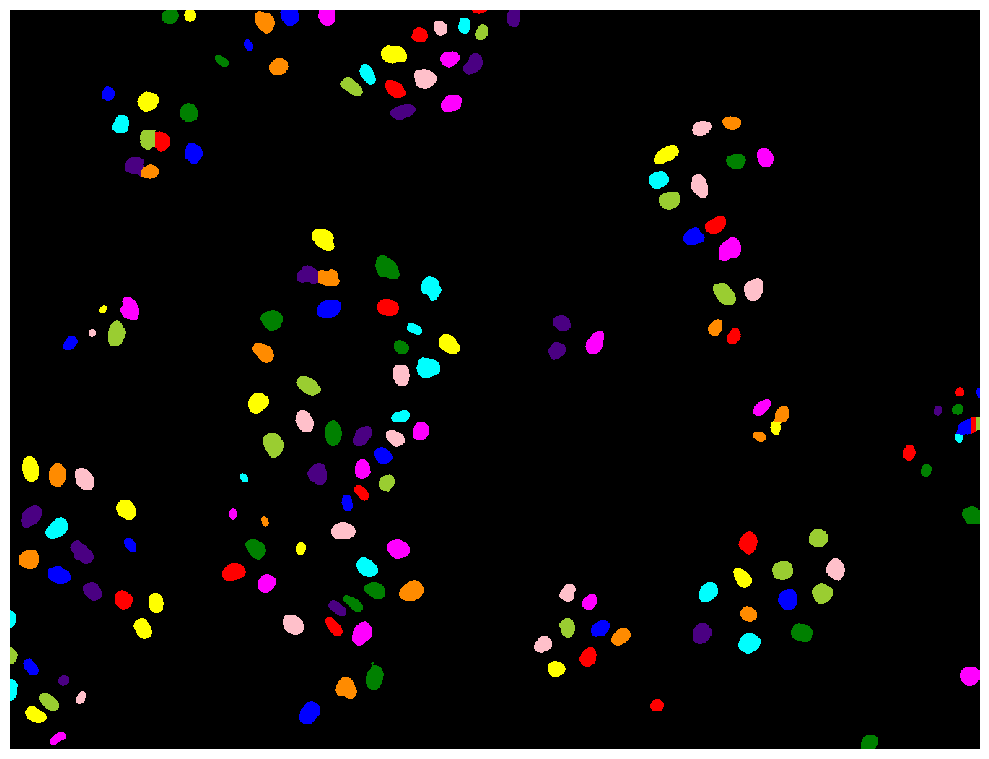

In [72]:
img = color.label2rgb(labels, bg_label=0)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, interpolation="nearest")
ax.axis("off")
plt.tight_layout()
plt.show()

### <p class="alert alert-info">Batch processing</p>

Since we now understand how to deal with the `Simple Segmentation` data from **Ilastik**, in order to obtain instance segmentation from all the *_Simple Segmentation.tif* files we generated, we can modify the batch script we used in the [classic segmentation methods](../classic/classic.md) section by simply adding the line of code where we select only the pixels with a value of 1 to only consider the nuclei.

***TODO: UPDATE LINK TO CLASSIC SEGMENTATION METHODS SECTION***

***TODO: UPDATE WITH THE METHOD EVA WILL WRITE***